In [136]:
#Imports
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid, GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline

def build_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_boundaries(clf, xx, yy, cmap=None):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    _, ax = plt.subplots()
    ax.pcolormesh(xx, yy, Z, cmap=cmap)
    return ax
    
def barplot_annotation(splot):
    for p in splot.patches:
        splot.annotate(f"{p.get_height():.2f} %", (p.get_x() + p.get_width()/2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

Step 1
Load Wine dataset

In [137]:
dataset = load_wine()

Step 2
Select the first two attributes for a 2D representation of the image

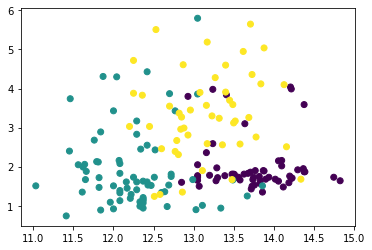

In [138]:
y_true = dataset.target
X = dataset.data[:,:2]

plt.scatter(X[:,0], X[:,1], c=y_true)
plt.show()


Step 3
Randomly split data into train, validation and test sets in proportion 5:2:3

In [139]:
X_trainVal, X_test, y_trainVal, y_test = train_test_split(X, y_true, test_size=3/10)
X_train, X_val, y_train, y_val = train_test_split(X_trainVal, y_trainVal, test_size=2/7)

scaler_val = StandardScaler()
scaler_test = StandardScaler()

#Scaler used for tuning stage
X_train = scaler_val.fit_transform(X_train)
X_val = scaler_val.transform(X_val)
#Scaler used for the final test prediction
X_trainVal = scaler_test.fit_transform(X_trainVal)
X_test = scaler_test.transform(X_test)

print(f"Proportion train:validation:test -> {round(10*len(X_train)/len(X))}:{round(10*len(X_val)/len(X))}:{round(10*len(X_test)/len(X))}")

Proportion train:validation:test -> 5:2:3


Step 4
For K = [1,3,5,7]:
1. Apply K-Nearest Neighbors
2. Plot the data and the decision boundaries
3. Evaluate the method on the validation set

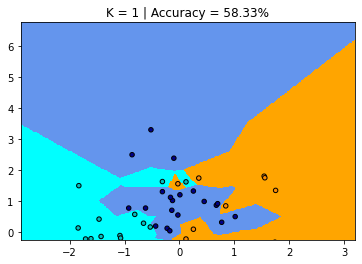

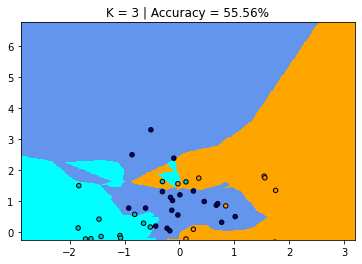

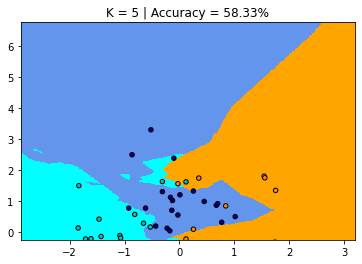

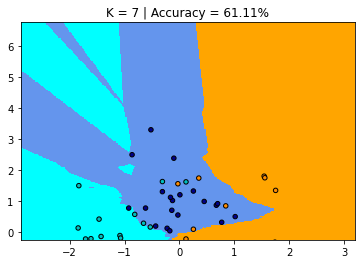

In [140]:
K = [1,3,5,7]
knns = [KNeighborsClassifier(n_neighbors=k) for k in K]

for knn in knns:
    knn.fit(X_train, y_train)

Ys_pred_knn = [knn.predict(X_val) for knn in knns]
accuracies_knn = [accuracy_score(y_val, y_pred) for y_pred in Ys_pred_knn]

# Create color maps
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

#Build meshgrid and plot boundaries
xx,yy = build_meshgrid(X_train[:, 0], X[:, 1])
for knn,k,acc in zip(knns,K,accuracies_knn):
    ax = plot_boundaries(knn, xx, yy, cmap_light)
    ax.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=cmap_bold, s=20, edgecolors="k")
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(f"K = {k} | Accuracy = {acc*100:.2f}%")
plt.show()

Step 5
Plot a graph showing how the accuracy on the validation set 
varies when changing K

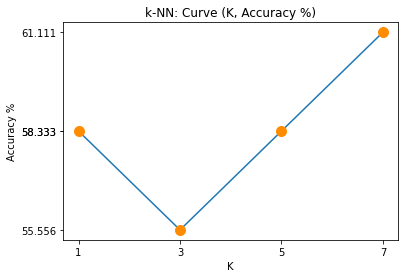

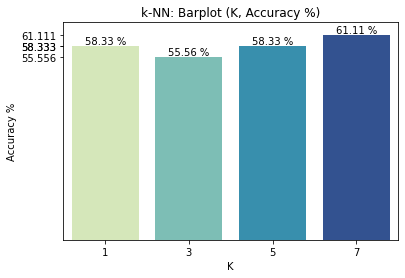

In [141]:
# Curve Graph
plt.figure()
plt.title('k-NN: Curve (K, Accuracy %)')
plt.scatter(K, np.array(accuracies_knn)*100, c="darkorange", s=100)
plt.plot(K, np.array(accuracies_knn)*100, zorder=-1)
plt.xlabel('K')
plt.ylabel('Accuracy %')
plt.minorticks_off()
plt.yticks(np.array(accuracies_knn)*100)
plt.xticks(K)

# Bar Plot
plt.figure()
plt.title('k-NN: Barplot (K, Accuracy %)')
splot = sns.barplot(x=K, y=np.array(accuracies_knn)*100, palette="YlGnBu")
barplot_annotation(splot)
plt.xlabel('K')
plt.ylabel('Accuracy %')
plt.ylim(np.max(accuracies_knn) + 10)
plt.minorticks_off()
plt.yticks(np.array(accuracies_knn)*100)

plt.show()

Step 6
How the boundaries change? Why?

[...]

Step 7
Use the best value of K and evaluate the model on the test set.
How well does it works?
[...]

In [142]:
best_arg = np.argmax(accuracies_knn)
best_k = K[best_arg]
best_knn = knns[best_arg]
best_knn.fit(X_trainVal, y_trainVal)
accuracy_test = best_knn.score(X_test, y_test)
print(f"Knn accuracy on test set: {accuracy_test*100:.2f}% using k = {best_k}")

Knn accuracy on test set: 81.48% using k = 7


Step 8
For C = [0.001, 0.01, 0.1, 1, 10, 100,1000]:
a. Train a linear SVM on the training set
b. Plot the data and the decision boundaries
c. Evaluate the method on the validation set

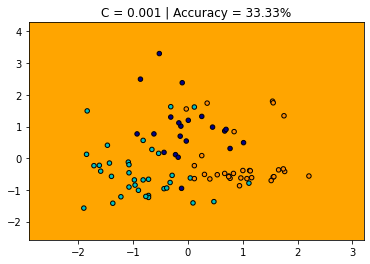

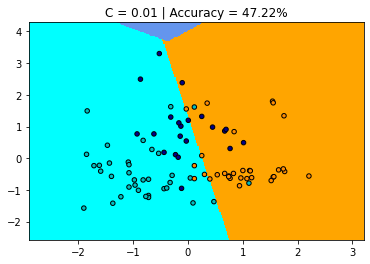

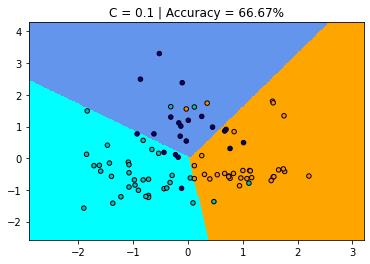

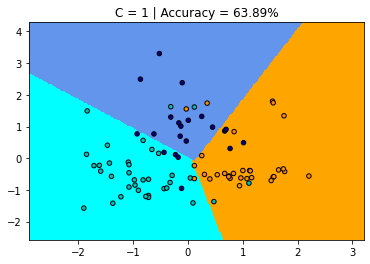

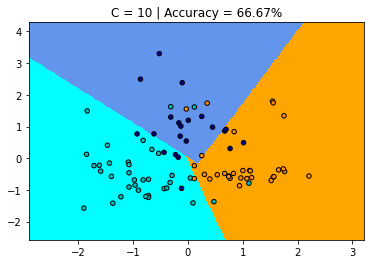

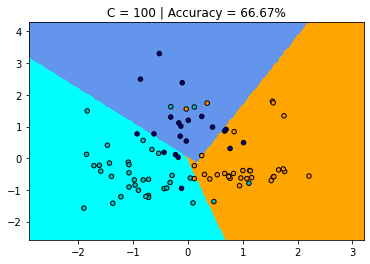

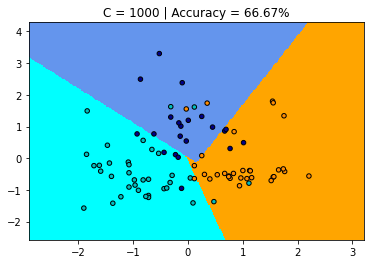

In [143]:
C = [0.001, 0.01, 0.1, 1, 10, 100,1000]
svms = [SVC(C=c, kernel='linear', gamma="auto") for c in C]

for svm in svms:
    svm.fit(X_train, y_train)

Ys_pred_svm = [svm.predict(X_val) for svm in svms]
accuracies_svm = [accuracy_score(y_val, y_pred) for y_pred in Ys_pred_svm]

#Build meshgrid and plot boundaries
xx,yy = build_meshgrid(X_train[:,0], X_train[:,1])
for svm,c,acc in zip(svms,C,accuracies_svm):
    ax = plot_boundaries(svm, xx, yy, cmap=cmap_light)
    ax.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=cmap_bold, s=20, edgecolors="k")
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(f"C = {c} | Accuracy = {acc*100:.2f}%")

plt.show()

Step 9
Plot a graph showing how the accuracy on the validation set varies when
changing C

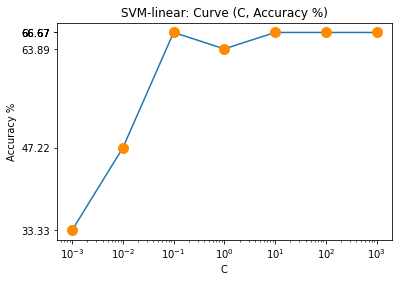

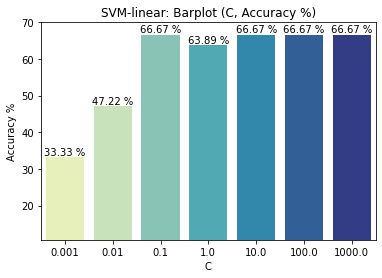

In [144]:
# Curve Graph
plt.figure()
plt.title('SVM-linear: Curve (C, Accuracy %)')
plt.scatter(C, np.array(accuracies_svm)*100, c="darkorange", s=100)
plt.plot(C, np.array(accuracies_svm)*100, zorder=-1)
plt.xlabel('C')
plt.ylabel('Accuracy %')
plt.minorticks_off()
plt.yticks(np.array(accuracies_svm)*100)
plt.xticks(C)
plt.xscale("log")
plt.xticks(C)

# Bar Plot
plt.figure()
plt.title('SVM-linear: Barplot (C, Accuracy %)')
splot = sns.barplot(x=C, y=np.array(accuracies_svm)*100, palette="YlGnBu")
barplot_annotation(splot)
plt.xlabel('C')
plt.ylabel('Accuracy %')
plt.ylim(np.max(accuracies_svm)+10)
plt.show()

Step 10
How the boundaries change? Why?
[...]

Step 11
Use the best value of C and evaluate the model on the test set.
How well does it works?
[...]

In [145]:
best_arg_svm = np.argmax(accuracies_svm)
best_c = C[best_arg_svm]
best_svm = svms[best_arg_svm]
best_svm.fit(X_trainVal, y_trainVal)
accuracy_test_svm = best_svm.score(X_test, y_test)
print(f"SVM-linear accuracy on test set: {accuracy_test_svm*100:.2f}% using C = {best_c}")

SVM-linear accuracy on test set: 85.19% using C = 0.1


Step 12.1
Repeat point 8. (train, plot, etc..), but this time use an RBF kernel

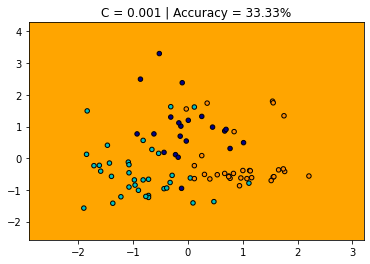

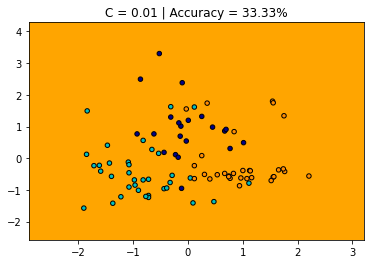

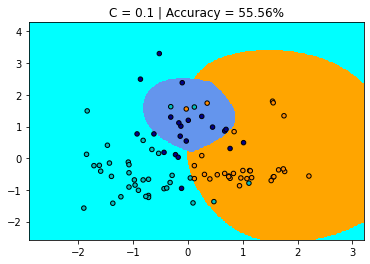

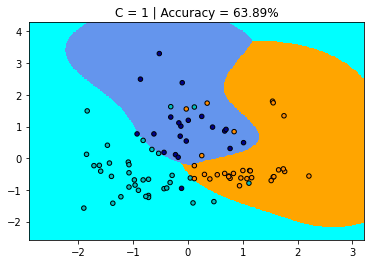

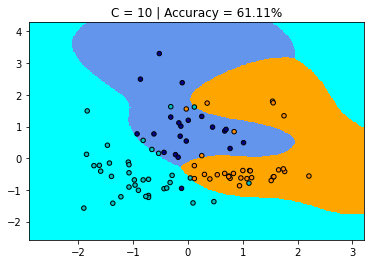

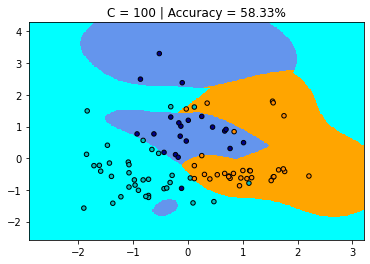

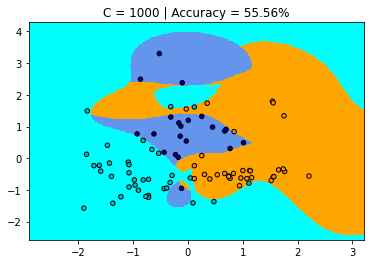

In [146]:
svms_rbf = [SVC(C=c, kernel='rbf', gamma='scale') for c in C]

for svm in svms_rbf:
    svm.fit(X_train, y_train)

Ys_pred_rbf = [svm.predict(X_val) for svm in svms_rbf]
accuracies_rbf = [accuracy_score(y_val, y_pred) for y_pred in Ys_pred_rbf]

#Build meshgrid and plot boundaries
xx,yy = build_meshgrid(X_train[:,0], X_train[:,1])
for svm,c,acc in zip(svms_rbf,C,accuracies_rbf):
    ax = plot_boundaries(svm, xx, yy, cmap=cmap_light)
    ax.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=cmap_bold, s=20, edgecolors="k")
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(f"C = {c} | Accuracy = {acc*100:.2f}%")

plt.show()

Step 12.2
Plot a graph showing how the accuracy on the validation set varies when
changing C

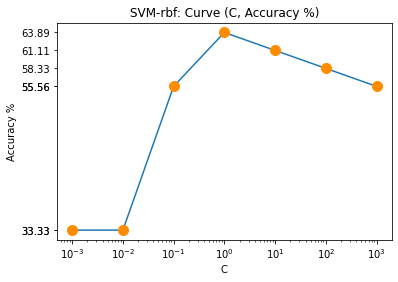

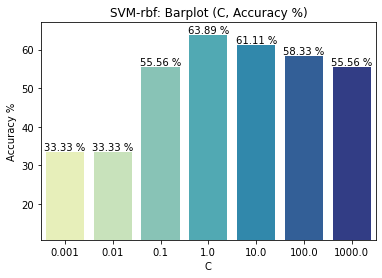

In [147]:
# Curve Graph
plt.figure()
plt.title('SVM-rbf: Curve (C, Accuracy %)')
plt.scatter(C, np.array(accuracies_rbf)*100, c="darkorange", s=100)
plt.plot(C, np.array(accuracies_rbf)*100, zorder=-1)
plt.xlabel('C')
plt.ylabel('Accuracy %')
plt.minorticks_off()
plt.yticks(np.array(accuracies_rbf)*100)
plt.xticks(C)
plt.xscale("log")
plt.xticks(C)

# Bar Plot
plt.figure()
plt.title('SVM-rbf: Barplot (C, Accuracy %)')
splot = sns.barplot(x=C, y=np.array(accuracies_rbf)*100, palette="YlGnBu")
barplot_annotation(splot)
plt.xlabel('C')
plt.ylabel('Accuracy %')
plt.ylim(np.max(accuracies_rbf) + 10)
plt.show()

Step 12.3
How the boundaries change? Why?
[...]

Step 13 / 14
Evaluate the best C on the test set
Are there any differences compared to the linear kernel? How are the
boundaries different?
[...]

In [148]:
best_arg_rbf = np.argmax(accuracies_rbf)
best_c_rbf = C[best_arg_rbf]
best_rbf = svms_rbf[best_arg_rbf]
best_rbf.fit(X_trainVal, y_trainVal)
accuracy_test_rbf = best_rbf.score(X_test, y_test)
print(f"SVM-rbf accuracy on test set: {accuracy_test_rbf*100:.2f}% using C = {best_c_rbf}")


SVM-rbf accuracy on test set: 85.19% using C = 1


Step 15
Perform a grid search of the best parameters for an RBF kernel: we will
now tune both gamma and C at the same time. Select an appropriate
range for both parameters. Train the model and score it on the validation
set. Evaluate the best parameters on the test set. Plot the decision
boundaries.

In [149]:
c_range = list(2.**np.arange(-5, 15, 2))
gamma_range = list(2.**np.arange(-15, 3, 2))

params = {
    "C":c_range,
    "gamma":gamma_range
}
grid = ParameterGrid(params)
svms_rbf = [SVC(kernel='rbf', **config) for config in grid]

for svm in svms_rbf:
    svm.fit(X_train, y_train)

Ys_pred_rbf = [svm.predict(X_val) for svm in svms_rbf]
accuracies_rbf = [accuracy_score(y_val, y_pred) for y_pred in Ys_pred_rbf]

In [150]:
#Evaluation on test set using the best combination (C,gamma)
best_arg_rbf = np.argmax(accuracies_rbf)
best_combination = grid[best_arg_rbf]
best_rbf = svms_rbf[best_arg_rbf]
best_rbf.fit(X_trainVal, y_trainVal)
accuracy_test_rbf = best_rbf.score(X_test, y_test)
print(f"SVM-rbf accuracy on test set: {accuracy_test_rbf*100:.2f}% using {best_combination}")

SVM-rbf accuracy on test set: 83.33% using {'gamma': 0.125, 'C': 0.5}


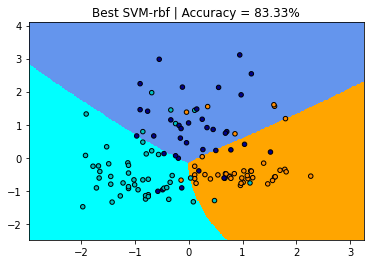

In [151]:
#Plot decision Boundaries 
xx,yy = build_meshgrid(X_trainVal[:,0], X_trainVal[:,1])
ax = plot_boundaries(best_rbf, xx, yy, cmap=cmap_light)
ax.scatter(X_trainVal[:,0], X_trainVal[:,1], c=y_trainVal, cmap=cmap_bold, s=20, edgecolors="k")
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_title(f"Best SVM-rbf | Accuracy = {accuracy_test_rbf*100:.2f}%")

plt.show()

Step 16
Merge the training and validation split. You should now have 70% training and 30% test data.

Step 17
Repeat the grid search for gamma and C but this time perform 5-fold
validation.

Step 18
Evaluate the parameters on the test set. Is the final score different? Why?

In [152]:
grid = GridSearchCV(SVC(),param_grid=params, scoring="accuracy", cv=5, n_jobs=-1)
grid.fit(X_trainVal, y_trainVal)
y_pred_final = grid.predict(X_test)
print(f"Best SVM-rbf CV| Accuracy = {accuracy_score(y_test, y_pred_final)*100:.2f}%")

Best SVM-rbf CV| Accuracy = 85.19%
